# Automated checkout using yolov8, text detection and recognition models with OpenVINO™

This Jupyter notebook demonstrates an automated checkout system that integrates object detection and text detection/recognition AI models. Utilizing YOLOv8 for object detection, the notebook efficiently identifies various items within a checkout frame, leveraging its robust and precise detection capabilities. To complement this, the notebook incorporates text detection and recognition within designated regions of interest. This combination allows for the extraction and interpretation of textual information—such as product labels and prices—from the detected items, facilitating a seamless and automated checkout process. The notebook is designed with detailed code explanations and visual outputs, making it accessible for users to understand and adapt the technology for various retail environments.

The tutorial consists of the following steps:
- Download the necessary models
- Convert the models to OpenVINO IR.
- Load models to OpenVINO engine 
- Live demo

## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [ ]:
%pip install -q "openvino-dev>=2024.0.0" "nncf>=2.9.0" paho-mqtt ipywidgets numpy
%pip install -q "torch>=2.1" "torchvision>=0.16" "ultralytics==8.1.42" onnx "opencv-python==4.9.0.80" tqdm --extra-index-url https://download.pytorch.org/whl/cpu


Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [2]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer

## Download models

Download Horizontal Text Detection and Text Recognition resnet Models

In [3]:
import openvino as ov
from IPython.display import Markdown, display

core = ov.Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"

model_dir.mkdir(exist_ok=True)

download_command = (
    f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {model_dir} --precision {precision}  --num_attempts 5"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {detection_model}, {recognition_model}..."))
!$download_command
display(Markdown(f"Finished downloading {detection_model}, {recognition_model}."))

detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")

## Convert models

The downloaded detection model is an Intel model, which is already in OpenVINO Intermediate Representation (OpenVINO IR) format. The text recognition model is a public model which needs to be converted to OpenVINO IR. Since this model was downloaded from Open Model Zoo, use Model Converter to convert the model to OpenVINO IR format.

The output of Model Converter will be displayed. When the conversion is successful, the last lines of output will include `[ SUCCESS ] Generated IR version 11 model.`

In [4]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {model_dir} --output_dir {model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

## Instantiate YoloV8 model
[back to top ⬆️](#Table-of-contents:)

There are [several models](https://docs.ultralytics.com/tasks/detect/) available in the original repository, targeted for different tasks. For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [5]:
models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

In [ ]:
from ultralytics import YOLO

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(models_dir / f"{DET_MODEL_NAME}.pt")
label_map = det_model.model.names

res = det_model()

### Convert YoloV8 model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [7]:
# object detection model
det_model_path = models_dir / f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml"
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)

## Text detection functions

### Select inference device for text detection
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [ ]:
import ipywidgets as widgets

text_device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

text_device

### Load a Text Detection Model
[back to top ⬆️](#Table-of-contents:)

In [9]:
text_detection_model = core.read_model(model=detection_model_path, weights=detection_model_path.with_suffix(".bin"))
text_detection_compiled_model = core.compile_model(model=text_detection_model, device_name=text_device.value)
text_detection_input_layer = text_detection_compiled_model.input(0)
text_output_key = text_detection_compiled_model.output("boxes")

### Load Pre and Post processing functions

In [10]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x for idx, shape in enumerate(box[:-1])]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(input_img, resized_image, boxes, threshold=0.3, conf_labels=True):
     # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
            input_img.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
                
    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        
        # Pick a confidence factor from the last place in an array.                
        conf = box[-1]                
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(input_img, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1)
                image_copy = input_img.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    input_img,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return input_img

## Text Recognition

Load the text recognition model and do inference on the detected boxes from the detection model.

### Load Text Recognition Model

In [11]:
recognition_model = core.read_model(model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin"))

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=text_device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

### Load inference text recognition function

In [12]:
from PIL import Image

def text_recognition_inferece(image,resized_image,boxes):
    if boxes is None or len(boxes) == 0:        
        return []
    # Calculate scale for image resizing.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y
    
    # Convert the image to grayscale for the text recognition model.
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get a dictionary to encode output, based on the model documentation.
    letters = "~0123456789abcdefghijklmnopqrstuvwxyz"
    
    # Prepare an empty list for annotations.
    annotations = list()
    cropped_images = list()
    # fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
    # Get annotations for each crop, based on boxes given by the detection model.
    for i, crop in enumerate(boxes):
        # Get coordinates on corners of a crop.
        (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
        image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))
    
        # Run inference with the recognition model.
        result = recognition_compiled_model([image_crop])[recognition_output_layer]
        
        # Squeeze the output to remove unnecessary dimension.
        recognition_results_test = np.squeeze(result)
    
        # Read an annotation based on probabilities from the output layer.
        annotation = list()
        for letter in recognition_results_test:
            parsed_letter = letters[letter.argmax()]
    
            # Returning 0 index from `argmax` signalizes an end of a string.
            if parsed_letter == letters[0]:
                break
            annotation.append(parsed_letter)
        annotations.append("".join(annotation))
        cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
        cropped_images.append(cropped_image)
    
    boxes_with_annotations = list(zip(boxes, annotations))
    return boxes_with_annotations

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

### Load function to draw a region of interest (ROI)



In [13]:
rect_points = []
drawing = False  # True if the mouse is pressed
ix, iy = -1, -1

global frame,original_frame

def draw_rectangle(event, x, y, flags, param):
    global ix, iy, drawing, frame, original_frame
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y  # Save the start point
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            temp_frame = original_frame.copy()
            cv2.rectangle(temp_frame, (ix, iy), (x, y), (0, 255, 0), 2)
            cv2.imshow("Video", temp_frame)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        rect_points[:] = [(ix, iy), (x, y)]  # Save the rectangle coordinates
        cv2.rectangle(frame, (ix, iy), (x, y), (0, 255, 0), 2)

### Load MQTT Function

In [14]:
import paho.mqtt.client as mqtt

def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected to MQTT Broker!")
    else:
        print("Failed to connect, return code %d\n", rc)

def on_disconnect(client, userdata, rc):
    if rc != 0:
        print("Unexpected disconnection.")

def connect_mqtt(broker_address, port, keepalive=60, client_id=""):
    # If client_id is an empty string or None, it should not be passed to Client()
    if client_id:
        client = mqtt.Client(client_id)
    else:
        client = mqtt.Client()  # Let paho generate a random client ID
    
    # Attach the connection and disconnection callbacks
    client.on_connect = on_connect
    client.on_disconnect = on_disconnect

    # Connect to the MQTT broker
    client.connect("127.0.0.1", 1883, keepalive)

    # Start the network loop in a separate thread
    client.loop_start()
    
    return client

def publish(client,data):
    payload = json.dumps(data)
    result = client.publish("ai/checkout", payload)
    # Check for successful publish
    if result.rc != mqtt.MQTT_ERR_SUCCESS:
        print("Failed to publish data.")
    

### Inference function

In [15]:
import collections
import time
from IPython import display
import numpy as np
import torch
import cv2
import openvino as ov
import ipywidgets as widgets
import json


device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
    mqtt=None,
):
    global frame,original_frame
    player = None
    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])

    det_model.predictor.inference = infer
    det_model.predictor.model.pt = False

    try:
        # Connect to MQTT
        mqtt_client = None
        if mqtt is not None:           
            mqttInfo = mqtt.split(":")
            mqtt_client = connect_mqtt(mqttInfo[0], mqttInfo[1])
        
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=60, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        frame = player.next()
            
        if use_popup:
            original_frame = frame.copy()
            cv2.namedWindow("Video", flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)            
            cv2.setMouseCallback("Video",draw_rectangle)
            # Display the first frame and wait for the user to draw the rectangle
            cv2.imshow("Video", frame)
            cv2.waitKey(0)  # Wait until any key is pressed

        processing_times = collections.deque()  

        # Blacklist object. Don't perform text detection and recognition on these objects. Update as needed.
        blacklist = ["person", "dining table", "sink", "bed"]
        
        while True:
            # Grab the frame.
            frame = player.next()

            if frame is None:
                print("Source ended")
                break

            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            
            
            if len(rect_points) == 2:
                cv2.rectangle(frame, rect_points[0], rect_points[1], (0, 255, 0), 2)
                # Crop the ROI
                roi = frame[max(0, rect_points[0][1]):rect_points[1][1], max(0, rect_points[0][0]):rect_points[1][0]]
            else:
                roi = frame.copy()
                        
            input_image = np.array(roi)

            # N,C,H,W = batch size, number of channels, height, width.
            N, C, H, W = text_detection_input_layer.shape           

            start_time = time.time()
            # Object detection yolov8 inference
            detections = det_model(input_image,verbose=False)
           
            # Initialize the list to hold JSON objects
            data_list = []

            # Perfom text detection and recognition on each detected object            
            for det in detections[0].boxes:
                xmin, ymin, xmax, ymax = map(int, det.xyxy[0].numpy())
                conf = det.conf.item()  # Confidence
                label = det_model.names[det.cls.item()]  # Class label from the detected object


                # Check if bounding box is valid
                if label not in blacklist:
                    if xmin < xmax and ymin < ymax:
                        object_roi = input_image[ymin:ymax, xmin:xmax]
                            
                        if object_roi.size != 0:  # Check if ROI is not empty
                            # Perform text detection
                            resized_image = cv2.resize(object_roi, (W, H))
                            text_input_img = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
                            text_boxes = text_detection_compiled_model([text_input_img])[text_output_key]
                            # Remove zero-only boxes.
                            text_boxes = text_boxes[~np.all(text_boxes == 0, axis=1)]
                                
                            # Text recognition
                            boxes_with_annotations = text_recognition_inferece(object_roi, resized_image, text_boxes)
                            recognized_texts = [text for box, text in boxes_with_annotations]
    
                            # Append data for this detection to the list
                            # Plotting Text results
                            roi = convert_result_to_image(object_roi, resized_image, boxes_with_annotations, conf_labels=True)                                                                                                    
                            json_object = {}
                            json_object["confidence"] = conf
                            json_object["label"] = label
                            json_object["Text"] = recognized_texts
                            data_list.append(json_object)                            
                                                                              
                            print(f"Confidence: {conf:.2f}, Label: {label}, Recognized Texts: {recognized_texts}")
                            
                        else:
                            print("Empty ROI detected, skipping this detection.")
                    else:
                        print("Invalid bounding box coordinates detected, skipping this detection.")

            stop_time = time.time()
            
            # Plotting object detection results
            roi = detections[0].plot()            

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            # Calculate mean processing time and FPS
            f_height, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time 

            target_img = frame if use_popup else roi

            
            # initial_y_offset = 20
            # line_spacing = 15

            # for obj in data_list:
            #     # Preparing text for display
            #     info_text = f"{obj['label']}, Texts: {', '.join(obj['Text'])}"
            #     text_size = cv2.getTextSize(info_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            #     text_x = target_img.shape[1] - text_size[0] - 10  # 10 pixels from the right edge
                            
            #     # Place text in the top right corner
            #     cv2.putText(target_img, info_text, (text_x, initial_y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            #     initial_y_offset += text_size[1] + line_spacing
            
            cv2.putText(
                img=target_img,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )    
            
            # Use this workaround if there is flickering.
            if use_popup:
                frame[max(0, rect_points[0][1]):rect_points[1][1], max(0, rect_points[0][0]):rect_points[1][0]] = roi
                cv2.rectangle(target_img, rect_points[0], rect_points[1], (0, 255, 0), 2)
                cv2.imshow("Video",frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Convert to JPEG for display in Jupyter notebook.                
                _, encoded_img = cv2.imencode(ext=".jpg", img=roi, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                i = display.Image(data=encoded_img.tobytes())
                display.clear_output(wait=True)
                display.display(i)

            # Publish to MQTT
            if mqtt is not None:
                publish(mqtt_client,data_list)
                data_list.clear()            
    
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()
        if mqtt is not None:
            mqtt_client.disconnect()
            mqtt_client.loop_stop()

### Run Live Object Detection
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

Note: The region of interest feature only works when use_popup is set to True. This will open a window to draw the bounding box using your mouse and left click.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

Run the object detection:

In [16]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "https://github.com/antoniomtz/sample-clips/raw/main/automated-small.mp4"

In [ ]:
device

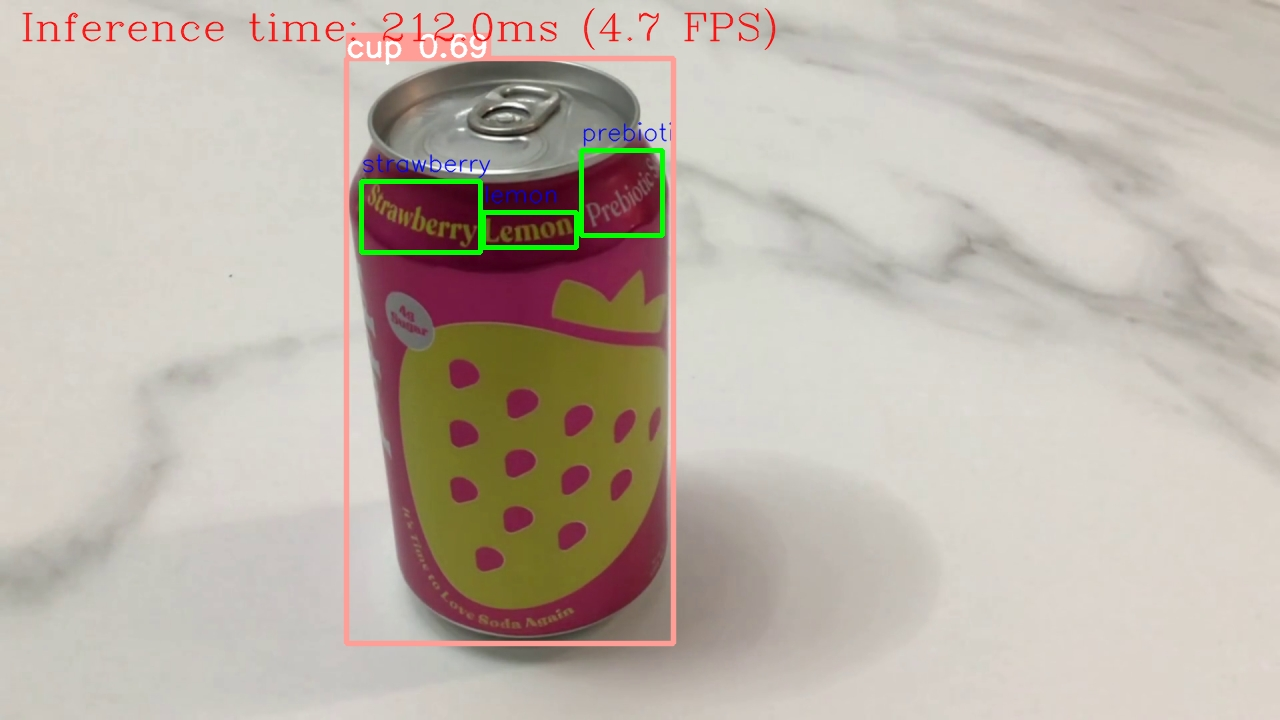

Interrupted


In [20]:
det_ov_model = core.read_model(det_model_path)

run_object_detection(
    source=VIDEO_SOURCE,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_ov_model,
    device=device.value,
    mqtt=None
)